# Comparing molecules among Datasets:
#### CSAR - DUD - DEKOIS2.0 - Cocristalized Molecules

In [1]:
import pickle
import pandas as pd
import numpy as np
from rdkit import Chem
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('..')
sns.set(style='white', context='talk', font_scale=0.8)

RDKit WARNING: [12:52:31] Enabling RDKit 2019.09.1 jupyter extensions


### Load the data

The following python object (*lig_datasets*) was created in the [2_Loading_molecules_from_db_with_rdkit]('./2_Loading_molecules_from_db_with_rdkit.ipynb') notebook. 

In [2]:
# Import the dictionary of dataframes with the rdkit molecules
file_rd_mols = './rdKit_db_molecules.obj'
with open(file_rd_mols, 'rb') as f:
    lig_datasets = pickle.load(f)

`lig_datasets` contains a python dictionary, where each element corresponds to a data frame of ligands belonging to a ligand library:

In [3]:
print(lig_datasets.keys())
print('\n' + '-'* 50 + '\nExample:')
lig_datasets['CSAR'].head()

dict_keys(['COCRYS', 'CSAR', 'DUD', 'DEKOIS'])

--------------------------------------------------
Example:


,Activity,mol_rdk,sanitized,MW,num_atoms
CS1,active,<rdkit.Chem.rdchem.Mol object at 0x7f0a74d410f0>,True,280.125,16
CS2,active,<rdkit.Chem.rdchem.Mol object at 0x7f0a74d41130>,True,193.250,14
CS3,active,<rdkit.Chem.rdchem.Mol object at 0x7f0a74d41170>,True,270.292,20
CS4,active,<rdkit.Chem.rdchem.Mol object at 0x7f0a74d411f0>,True,271.276,20
CS5,inactive,<rdkit.Chem.rdchem.Mol object at 0x7f0a74d41270>,True,348.244,21


## Using `RDKit` to evaluate some molecular descriptors
##### The following function computes  some features like Molecular Mass, number of heavy atoms, number of rotamers and number of rings.

In [4]:
from rdkit.Chem import Descriptors, Lipinski, rdMolDescriptors
from rdkit.Chem.rdmolops import FastFindRings

# Get the molecular weight and # of heavy atoms for each ligand
for dataset in lig_datasets.values():
    # molecular weight
    dataset['MW'] = [round(Descriptors.MolWt(m), 3) for m in dataset['mol_rdk']]
    # number of heavy atoms
    dataset['num_atoms'] = [round(Chem.Lipinski.HeavyAtomCount(m), 3) for m in dataset['mol_rdk']]
    # Update ring properties
    mol_update = [FastFindRings(m) for m in dataset['mol_rdk']]
    # Get number of rotamers
    dataset['num_rot'] = [round(Chem.Lipinski.NumRotatableBonds(m), 3) for m in dataset['mol_rdk']]
    # Get number of rings
    dataset['num_rings'] = [round(rdMolDescriptors.CalcNumRings(m), 3) for m in dataset['mol_rdk']]
    


## Plots

In [5]:
# Import some helper functions
from helper_functions_2 import violin_plot_helper, swarm_plot_helper

### Molecular Mass
#### Swarm plot

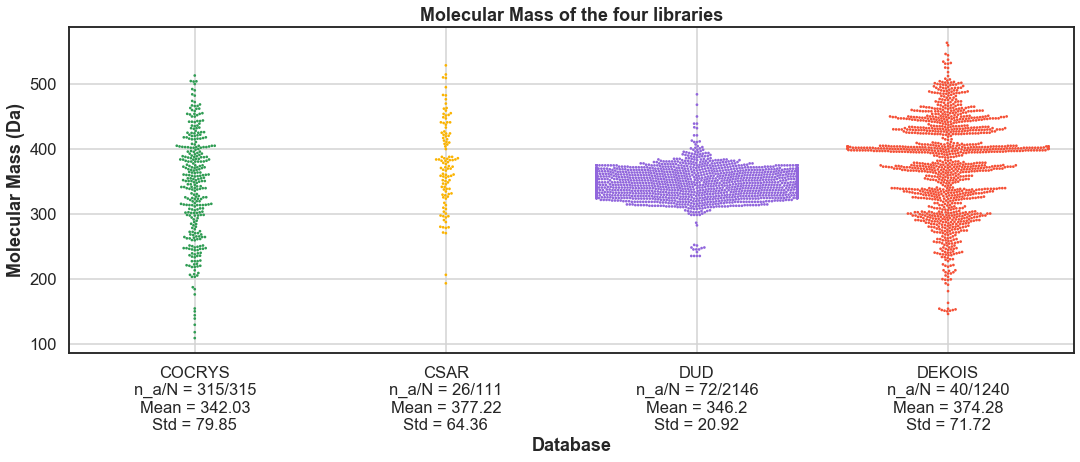

In [6]:
# Declare a color palette
palette = ['#2F9C53', '#FBB300', '#9166DC', '#F55036']
swarm_plot_helper('MW', lig_datasets,
                   title = 'Molecular Mass of the four libraries', palette= palette,
                   xlabel= 'Database', ylabel = 'Molecular Mass (Da)', split=False, size=2.7)
# too many points!! let's use a violin plot instead...

#### Violin plot

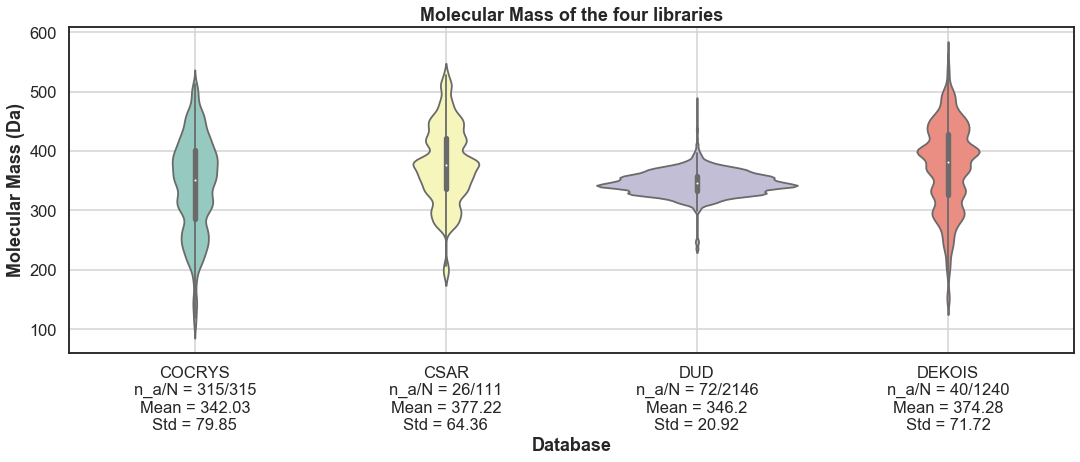

In [7]:
violin_plot_helper('MW', lig_datasets,
                   title = 'Molecular Mass of the four libraries', palette= 'Set3',
                   xlabel= 'Database', ylabel = 'Molecular Mass (Da)', split=False, )

#### Split the datasets into Binders and no binders

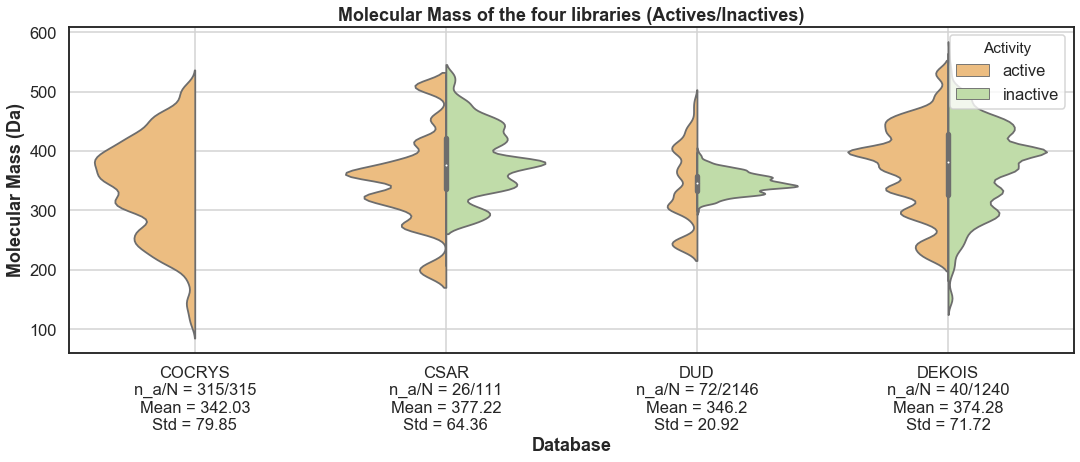

In [8]:
violin_plot_helper('MW', lig_datasets,
                   title = 'Molecular Mass of the four libraries (Actives/Inactives)',
                   xlabel= 'Database', ylabel = 'Molecular Mass (Da)', split=True)

### Number of Heavy Atoms

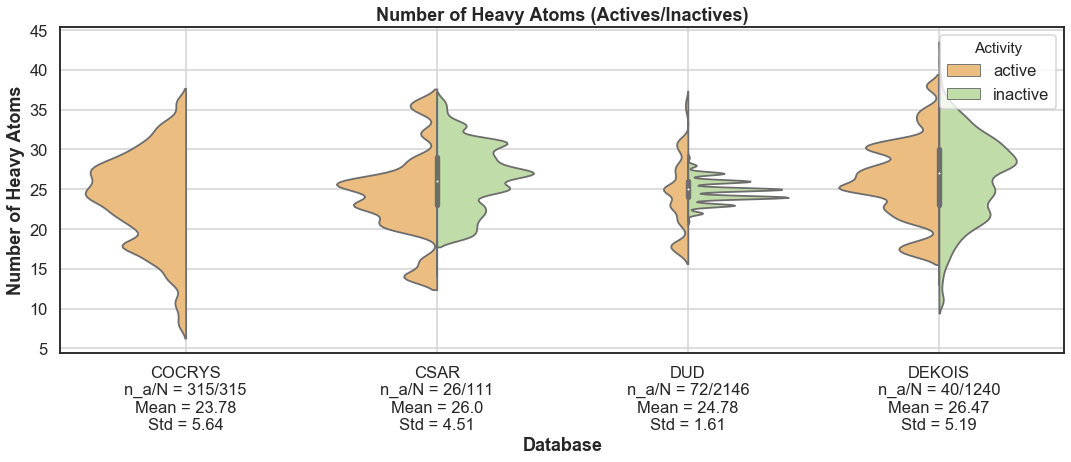

In [9]:
violin_plot_helper('num_atoms', lig_datasets,
                   title = 'Number of Heavy Atoms (Actives/Inactives)',
                   xlabel= 'Database', ylabel = 'Number of Heavy Atoms', split=True)

### Number of Rings

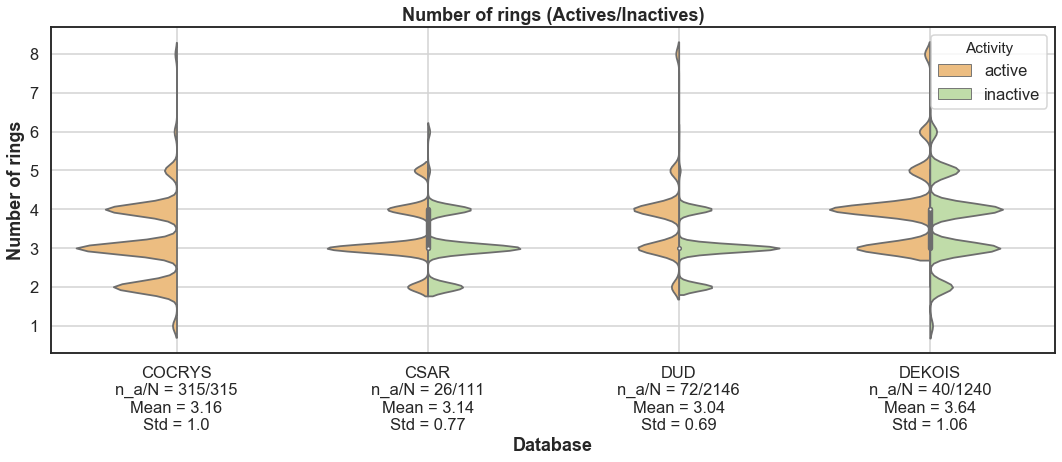

In [10]:
violin_plot_helper('num_rings', lig_datasets,
                   title = 'Number of rings (Actives/Inactives)',
                   xlabel= 'Database', ylabel = 'Number of rings', split=True)

### Number of Rotatable Bonds

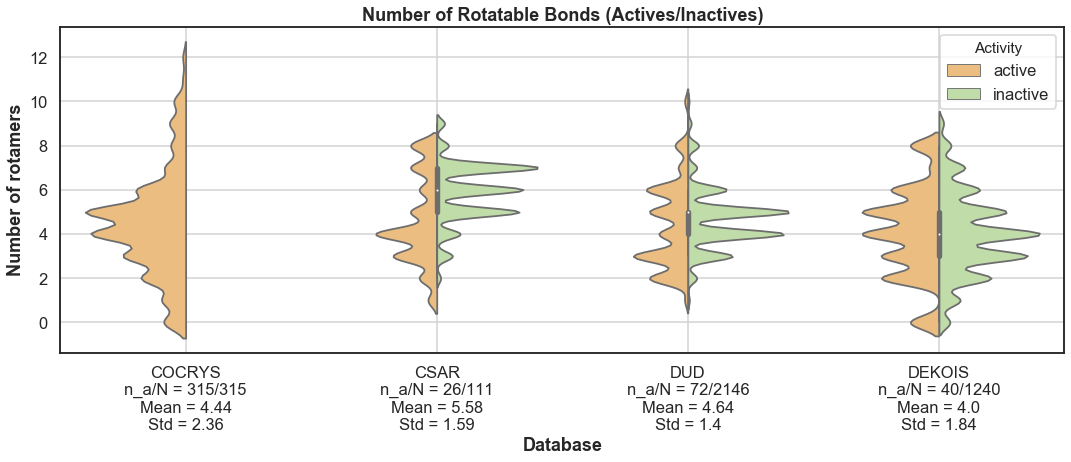

In [11]:
violin_plot_helper('num_rot', lig_datasets,
                   title = 'Number of Rotatable Bonds (Actives/Inactives)',
                   xlabel= 'Database', ylabel = 'Number of rotamers', split=True)

# Fingerprints Computation
Useful resource to compare the different fingerprints inside RDKit:
[Comparing Fingerprints](http://rdkit.blogspot.com/2013/10/comparing-fingerprints-to-each-other.html)

> **Just for testing we are going to use the following fingerprints: _MACCS Keys_ and _RDKFingerprints_ (RDKit Topological Fingerprints).**

### MACCS keys
- **MACCS key** is a binary fingerprint (**166-bit-long**).
- Each bit position represents the presence (1) or absence (0) of a pre-defined structural feature.
- The feature definitions for the MACCS keys are available [here](https://github.com/rdkit/rdkit/blob/master/rdkit/Chem/MACCSkeys.py).
- Usual metric to compare these fp is Tanimoto


In [12]:
from rdkit.Chem import MACCSkeys

for dataset in lig_datasets.values():
    # MACCS Keys Fingetprints
    dataset['fps_maccs'] = [MACCSkeys.GenMACCSKeys(i) for i in dataset['mol_rdk']]

### RDKFingerprint: Path-based Fingerprints
Useful sources:
[RDKit: topological-fingerprints](https://www.rdkit.org/docs/GettingStartedInPython.html#topological-fingerprints), [Molecular_Similarity Assignment](https://chem.libretexts.org/Courses/Intercollegiate_Courses/Cheminformatics_OLCC_(2019)/6%3A_Molecular_Similarity/6.4%3A_Python_Assignment)

In [13]:
for dataset in lig_datasets.values():
    # RDKit Fingetprints
    dataset['fps_rdk'] = [Chem.RDKFingerprint(i, fpSize=2048, minPath=1, maxPath=7)
                          for i in dataset['mol_rdk']]

#### Helper functions to draw and compare matching molecules  between mol libraries

In [14]:
from helper_functions_2 import draw_matched_ligs, compare_lig_db

### Matched molecules between databases

##### Using MACCS Keys Fps

In [15]:
%%time
matched_ligands = compare_lig_db('fps_maccs', lig_datasets, method = 'tanimoto')


COCRYS 	 CSAR
CK2 	 CS12
18K 	 CS18
03K 	 CS3
09K 	 CS9
20K 	 CS20
42K 	 CS242
61K 	 CS261
62K 	 CS262

COCRYS 	 DUD
NW1 	 ligand_66
1PU 	 ligand_24
MBP 	 ligand_34
MBP 	 ligand_35
UN4 	 ligand_40
UN4 	 ligand_41
2A6 	 ligand_44
2A6 	 ligand_45
6CP 	 ligand_42
6CP 	 ligand_43
4SP 	 ligand_9
LS1 	 ligand_21
LS4 	 ligand_23
ST8 	 ligand_27
N76 	 ligand_9
UCN 	 ligand_16
OLO 	 ligand_11
RRC 	 ligand_12
D42 	 ligand_64
D42 	 ligand_65
RC8 	 ligand_12
G6T 	 ligand_9
F9Z 	 ligand_69

COCRYS 	 DEKOIS
1PU 	 ligand_27

CSAR 	 DUD
CS241 	 ligand_71

CSAR 	 DEKOIS

DUD 	 DEKOIS
ligand_2 	 ligand_37
ligand_14 	 ligand_22
ligand_15 	 ligand_3
ligand_24 	 ligand_27
decoy_686 	 decoy_808
decoy_687 	 decoy_808
CPU times: user 1min 33s, sys: 181 ms, total: 1min 34s
Wall time: 1min 34s


#### Venn diagram


<img src="venn_diag_mol_libraries.png" alt="Venn" style="width: 350px;"/>

#### As an example, let's visualize a molecule share by CSAR and DUD libraries.

=========================     CSAR-DUD     =========================


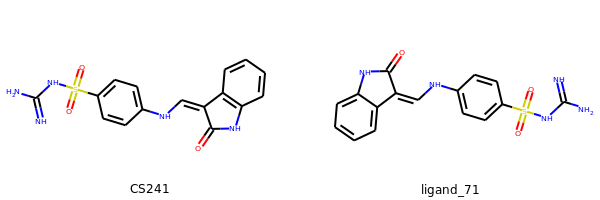

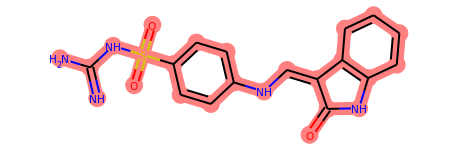

In [43]:
draw_matched_ligs('CSAR-DUD', matched_ligands)

***
# Clustering and Dimensionality Reduction

## t-SNE

In [24]:
# Get the active/inactive array
actives_ = []
databases_ = []
for name, dataset in lig_datasets.items():
    actives_ = actives_ + dataset['Activity'].to_list()
    databases_ = databases_ + ([name] * len(dataset['Activity']))
activity_array = np.array(actives_)
databases_array = np.array(databases_)

# Get the number of molecules
n_molecuels = len(activity_array)

### Using MACCS Keys

In [25]:
# Extrac the fingerprint values
fp_mccs_list = []
num_of_rings_list = []
for dataset in lig_datasets.values():
    # Fingerprints
    fp_array = [fp for fp in dataset['fps_maccs']]
    fp_mccs_list = fp_mccs_list + fp_array
    # Number of rings (just to add another dimesion in the scatter plot; using the point's size)
    num_ring_array = [n for n in dataset['num_rings']]
    num_of_rings_list = num_of_rings_list + num_ring_array

fp_mccs_array = np.array([np.array(i) for i in fp_mccs_list])

#### Perform the tSNE

In [26]:
%%time
from sklearn.manifold import TSNE
tsne_maccs = TSNE().fit_transform(fp_mccs_array)

CPU times: user 1min 45s, sys: 1min 26s, total: 3min 11s
Wall time: 32.1 s


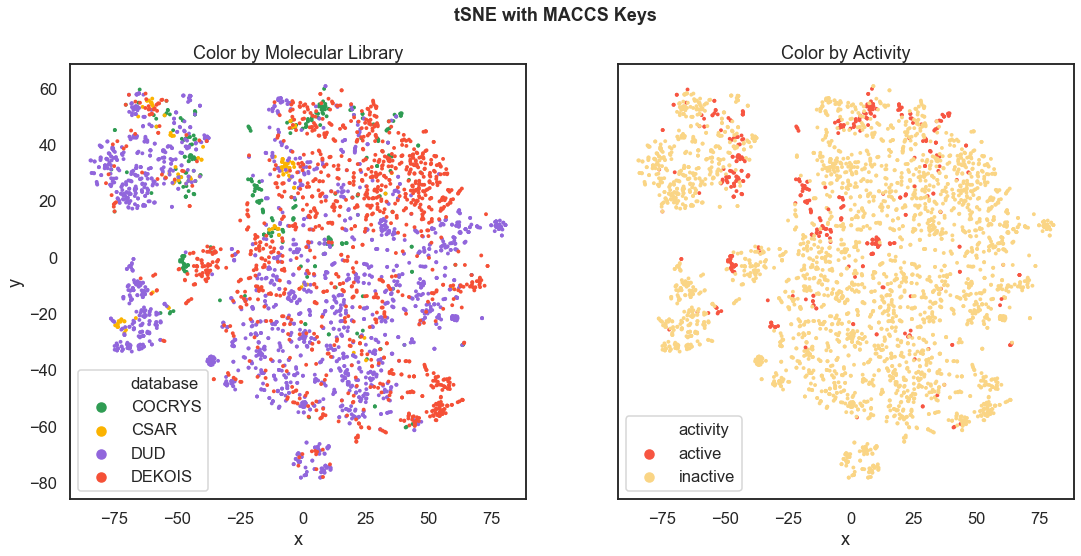

In [27]:
# Create a dataframe for plotling
plt.rcParams["lines.markeredgewidth"] = 0.5
tsne_mccs_df = pd.DataFrame({'x': tsne_maccs[:,0], 'y': tsne_maccs[:,1],
             'activity': activity_array, 'database': databases_array})

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(18,8))
f.suptitle('tSNE with MACCS Keys', fontsize=18, fontweight='bold')
sns.scatterplot(data = tsne_mccs_df, x = 'x', y = 'y', 
                hue='database', s = 15, ax=ax1,
                palette=palette, linewidth=0)
sns.scatterplot(data = tsne_mccs_df, x = 'x', y = 'y', 
                hue='activity', s = 15, ax=ax2,
                 palette=['#F75541', '#FAD585'], linewidth=0)
ax1.title.set_text('Color by Molecular Library')
ax2.title.set_text('Color by Activity')
plt.show()

### Using RDKit Topological Fingerprints

In [28]:
# Extrac the fingerprint values
fp_rdk_list = []

for dataset in lig_datasets.values():
    # Fingerprints
    fp_array = [fp for fp in dataset['fps_rdk']]
    fp_rdk_list = fp_rdk_list + fp_array

fp_rdk_array = np.array([np.array(i) for i in fp_rdk_list])

In [29]:
%%time
tsne_rdk = TSNE().fit_transform(fp_rdk_array)

CPU times: user 2min 59s, sys: 1min 5s, total: 4min 4s
Wall time: 1min 27s


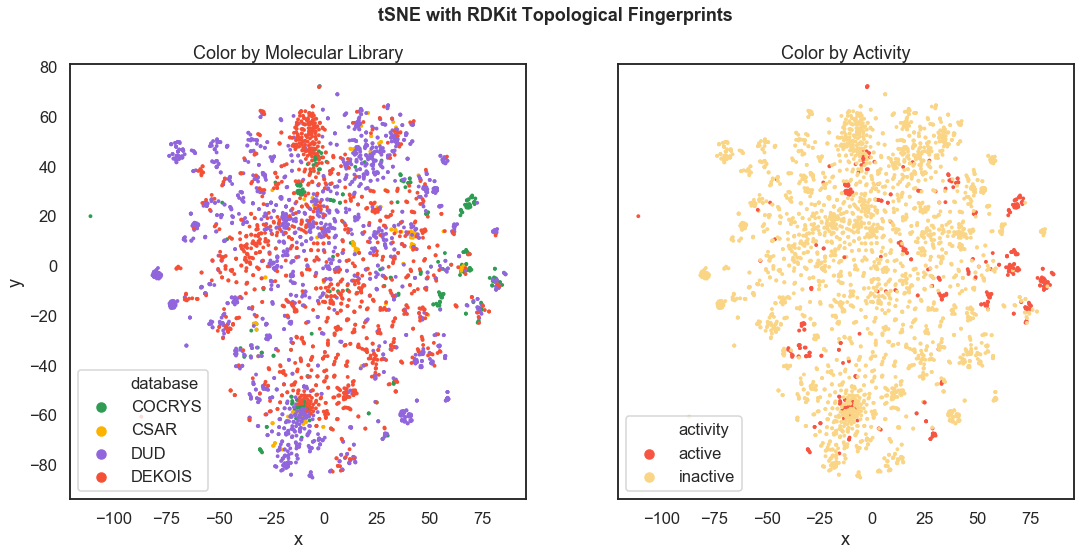

In [30]:
# Create a dataframe for plotling
tsne_df_rdk = pd.DataFrame({'x': tsne_rdk[:,0], 'y': tsne_rdk[:,1],
             'activity': activity_array, 'database': databases_array})

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(18,8))
f.suptitle('tSNE with RDKit Topological Fingerprints', fontsize=18, fontweight='bold')
sns.scatterplot(data = tsne_df_rdk, x = 'x', y = 'y', 
                hue='database', s = 15, ax=ax1,
                palette=palette, linewidth=0)
sns.scatterplot(data = tsne_df_rdk, x = 'x', y = 'y', 
                hue='activity', s = 15, ax=ax2,
                palette=['#F75541', '#FAD585'], linewidth=0)
ax1.title.set_text('Color by Molecular Library')
ax2.title.set_text('Color by Activity')
plt.show()

# cMDS

### Using MACCS Keys

#### Compute the dissimilarity matrix using Tanimoto

In [31]:
from rdkit import DataStructs

In [32]:
n_ = len(fp_mccs_array)
tan_mtx_mcc = np.zeros((n_, n_))

# Compute Tanimoto between each pair of ligands
for i in range(n_):
    sim = DataStructs.BulkDiceSimilarity(fp_mccs_list[i], fp_mccs_list[:])
    tan_mtx_mcc[i] = sim
    
# convert to a disimilarity matrix
dist_mtx_mcc = abs(tan_mtx_mcc - 1)

#### Compute the cMDS

In [33]:
from modules.MDS import cMDS

In [34]:
# perform the mds from the sitance matrix
mds_mcc = cMDS(dist_mtx_mcc)

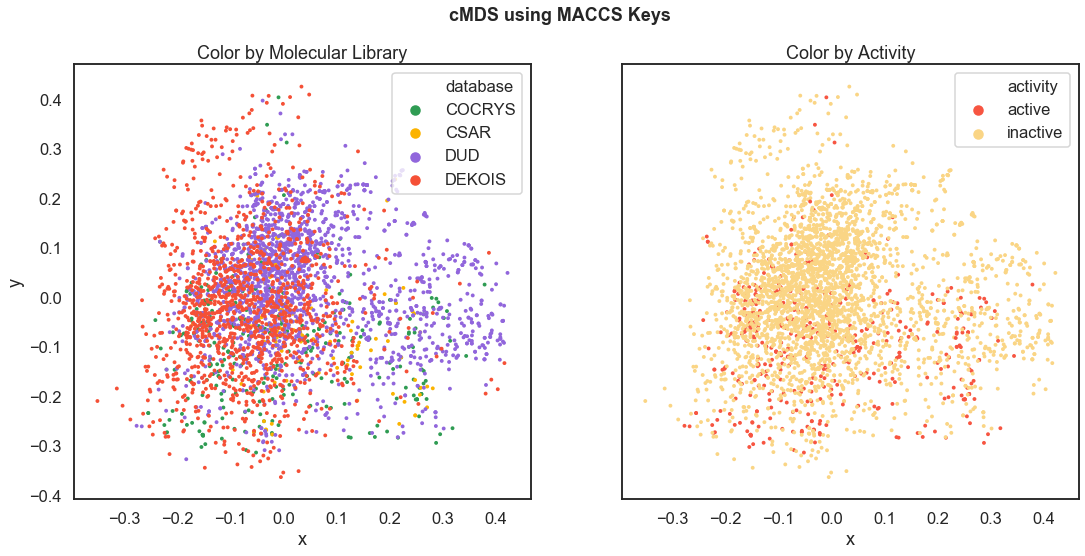

In [35]:
# Create a dataframe for plotling
mds_df_mccs = pd.DataFrame({'x': mds_mcc[0][0], 'y': mds_mcc[0][1],
             'activity': activity_array, 'database': databases_array})

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(18,8))
f.suptitle('cMDS using MACCS Keys', fontsize=18, fontweight='bold')
sns.scatterplot(data = mds_df_mccs, x = 'x', y = 'y', 
                hue='database', s = 15, ax=ax1,
                palette=palette, linewidth=0)
sns.scatterplot(data = mds_df_mccs, x = 'x', y = 'y', 
                hue='activity', s = 15, ax=ax2,
                palette=['#F75541', '#FAD585'], linewidth=0)
ax1.title.set_text('Color by Molecular Library')
ax2.title.set_text('Color by Activity')
plt.show()

### Using RDKFingerprints
#### Compute the dissimilarity matrix using Tanimoto

In [37]:
n_ = len(fp_rdk_array)
tan_mtx_rdk = np.zeros((n_, n_))

# Compute the dissimilarity matrix using Tanimoto
for i in range(n_):
    sim = DataStructs.BulkDiceSimilarity(fp_rdk_list[i], fp_rdk_list[:])
    tan_mtx_rdk[i] = sim
    
# convert to a disimilarity matrix
dist_mtx_rdk = abs(tan_mtx_rdk - 1)

#### Compute the cMDS

In [38]:
# perform the mds from the sitance matrix
mds_rdk = cMDS(dist_mtx_rdk)

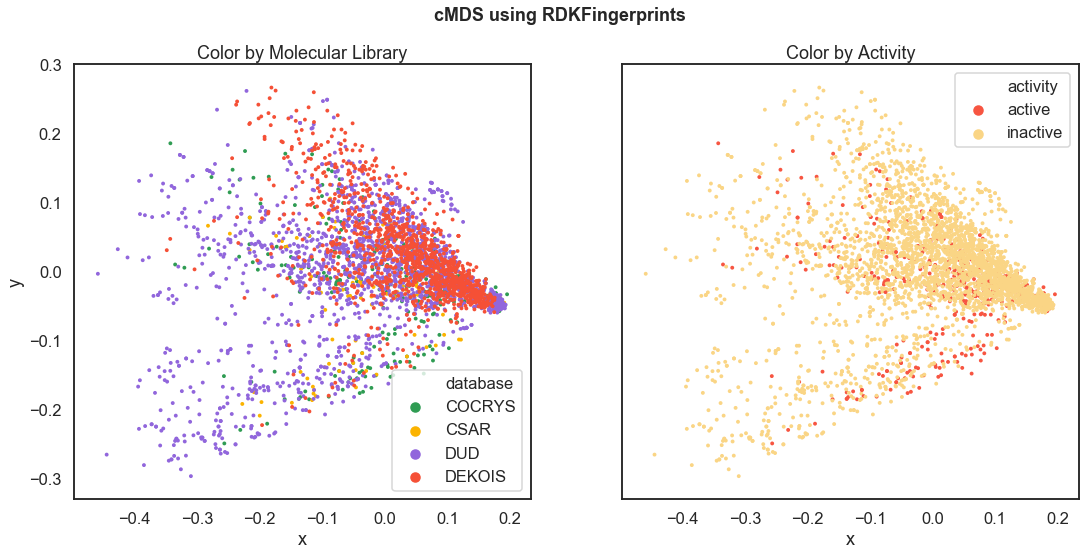

In [39]:
# Create a dataframe for plotling
mds_df_rdk = pd.DataFrame({'x': mds_rdk[0][0], 'y': mds_rdk[0][1],
             'activity': activity_array, 'database': databases_array})

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(18,8))
f.suptitle('cMDS using RDKFingerprints', fontsize=18, fontweight='bold')
sns.scatterplot(data = mds_df_rdk, x = 'x', y = 'y', 
                hue='database', s = 15, ax=ax1,
                palette=palette, linewidth=0)
sns.scatterplot(data = mds_df_rdk, x = 'x', y = 'y', 
                hue='activity', s = 15, ax=ax2,
                palette=['#F75541', '#FAD585'], linewidth=0)
ax1.title.set_text('Color by Molecular Library')
ax2.title.set_text('Color by Activity')
plt.show()

In [ ]:
### TO DO:

In [ ]:
# ###  Circular Fingerprints
# - Hashed fingerprints.
# - They are generated by exhaustively enumerating 'circular' fragments, i.e., considering all atoms within a radius (in terms of connectivity; number of bonds that separates two atoms) from each heavy atom and then hashing these fragments into a fixed.length bitstring.

# #### Extended Connectivity Fingerprint ECFP
# - Extended Connectivity Fingerprints are circular fingerprints that represent molecular structures by means of circular atom neighborhoods.
# - They are binary strings (), representing the presence/absence of particular substructures.
# - They are not predefined and can represent a huge number of different molecular features (including stereochemical information).
# - Usaul metric to compare these FP is Dice.